<a href="https://colab.research.google.com/github/chienrya8/acled/blob/main/acled_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ML Engineer Take-Home Assessment: Event Data Trends and Analysis

Part 2

10/19/2025

Ryan Chien

# Read Data

In [1]:
# get local acled data
from google.colab import files
uploaded = files.upload()

Saving Africa_aggregated_data_up_to-2025-10-04.xlsx to Africa_aggregated_data_up_to-2025-10-04 (1).xlsx


In [2]:
# read and preview
import pandas as pd
df = pd.read_excel("Africa_aggregated_data_up_to-2025-10-04.xlsx")

In [3]:
df = df.sort_values(by=["WEEK", "REGION", "COUNTRY"])
df.head(5)

,WEEK,REGION,COUNTRY,ADMIN1,EVENT_TYPE,SUB_EVENT_TYPE,EVENTS,FATALITIES,POPULATION_EXPOSURE,DISORDER_TYPE,ID,CENTROID_LATITUDE,CENTROID_LONGITUDE
163263,1996-12-28,Eastern Africa,Rwanda,West,Battles,Armed clash,1,1,NaN,Political violence,2653.0,-2.1271,29.3906
241927,1996-12-28,Eastern Africa,Uganda,Gulu,Battles,Armed clash,1,4,NaN,Political violence,4015.0,3.0186,32.3885
246355,1996-12-28,Eastern Africa,Uganda,Mityana,Battles,Armed clash,1,5,NaN,Political violence,4077.0,0.4533,32.0776
9289,1996-12-28,Middle Africa,Angola,Bie,Violence against civilians,Attack,2,40,NaN,Political violence,3723.0,-12.4421,17.4172
35458,1996-12-28,Middle Africa,Central African Republic,Bangui,Battles,Armed clash,2,4,NaN,Political violence,3773.0,4.3755,18.5531


# Feature Engineering

**Analyze**

Violence self-correlation:
- ... can we fit a model to identify anomalous fatalities?
- ... fit model where y=fatalities_region_wk_t and x={features}_region_wk_t-1

Violence neighbor-correlation:
- ... which regions are correlated to others?
- ... fit model where y=fatalities_region_wk_t and x={features}_notregion_wk_t-1

Y vars:
* FATALITIES: int

X vars:
* FATALITIES: int
* EVENTS: int
* POPULATION_EXPOSURE: int (control)
* EVENT_TYPE: cat
* DISORDER_TYPE: cat

Feature descriptions: https://acleddata.com/methodology/acled-codebook#event-types-table

In [4]:
# generate categoricals through one hot encoding
CATEGORICAL_COLS = ["EVENT_TYPE", "DISORDER_TYPE"]
df_cat = pd.get_dummies(df, columns=CATEGORICAL_COLS)
df_cat.head(5)

,WEEK,REGION,COUNTRY,ADMIN1,SUB_EVENT_TYPE,EVENTS,FATALITIES,POPULATION_EXPOSURE,ID,CENTROID_LATITUDE,...,EVENT_TYPE_Battles,EVENT_TYPE_Explosions/Remote violence,EVENT_TYPE_Protests,EVENT_TYPE_Riots,EVENT_TYPE_Strategic developments,EVENT_TYPE_Violence against civilians,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments
163263,1996-12-28,Eastern Africa,Rwanda,West,Armed clash,1,1,NaN,2653.0,-2.1271,...,True,False,False,False,False,False,False,True,False,False
241927,1996-12-28,Eastern Africa,Uganda,Gulu,Armed clash,1,4,NaN,4015.0,3.0186,...,True,False,False,False,False,False,False,True,False,False
246355,1996-12-28,Eastern Africa,Uganda,Mityana,Armed clash,1,5,NaN,4077.0,0.4533,...,True,False,False,False,False,False,False,True,False,False
9289,1996-12-28,Middle Africa,Angola,Bie,Attack,2,40,NaN,3723.0,-12.4421,...,False,False,False,False,False,True,False,True,False,False
35458,1996-12-28,Middle Africa,Central African Republic,Bangui,Armed clash,2,4,NaN,3773.0,4.3755,...,True,False,False,False,False,False,False,True,False,False


In [5]:
df_cat.columns

Index(['WEEK', 'REGION', 'COUNTRY', 'ADMIN1', 'SUB_EVENT_TYPE', 'EVENTS',
       'FATALITIES', 'POPULATION_EXPOSURE', 'ID', 'CENTROID_LATITUDE',
       'CENTROID_LONGITUDE', 'EVENT_TYPE_Battles',
       'EVENT_TYPE_Explosions/Remote violence', 'EVENT_TYPE_Protests',
       'EVENT_TYPE_Riots', 'EVENT_TYPE_Strategic developments',
       'EVENT_TYPE_Violence against civilians', 'DISORDER_TYPE_Demonstrations',
       'DISORDER_TYPE_Political violence',
       'DISORDER_TYPE_Political violence; Demonstrations',
       'DISORDER_TYPE_Strategic developments'],
      dtype='object')

In [6]:
# now aggregate by week, country
GROUP_COLS = ["WEEK", "COUNTRY"]
one_hot_idx = sum([df_cat.columns.str.startswith(cat) for cat in CATEGORICAL_COLS])
one_hot_idx = [bool(i) for i in one_hot_idx]
ONE_HOT_COLS = df_cat.columns.values[one_hot_idx].tolist()
FEATURE_COLS = ["FATALITIES", "EVENTS", "POPULATION_EXPOSURE"] + ONE_HOT_COLS
df_agg = df_cat.groupby(GROUP_COLS)[FEATURE_COLS].sum()
df_agg = df_agg.reset_index()
df_agg.head(5)

,WEEK,COUNTRY,FATALITIES,EVENTS,POPULATION_EXPOSURE,EVENT_TYPE_Battles,EVENT_TYPE_Explosions/Remote violence,EVENT_TYPE_Protests,EVENT_TYPE_Riots,EVENT_TYPE_Strategic developments,EVENT_TYPE_Violence against civilians,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments
0,1996-12-28,Algeria,9,3,0.0,0,0,0,0,0,3,0,3,0,0
1,1996-12-28,Angola,40,2,0.0,0,0,0,0,0,1,0,1,0,0
2,1996-12-28,Central African Republic,4,2,0.0,1,0,0,0,0,0,0,1,0,0
3,1996-12-28,Egypt,1,1,0.0,1,0,0,0,0,0,0,1,0,0
4,1996-12-28,Libya,8,1,0.0,0,0,0,0,0,1,0,1,0,0


In [7]:
# now fill in missing observations with 0
def fill_missing_weeks_multiindex(df, group_col, date_col, value_col):
    """
    Fill missing week observations with zero using MultiIndex.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe with date column
    group_col : str
        Column to group by (e.g., 'country', 'region')
    date_col : str
        Date column name
    value_col : str or list
        Value column(s) to aggregate/fill

    Returns:
    --------
    DataFrame : Reindexed dataframe with missing weeks filled as zero

    Example:
    --------
    df_filled = fill_missing_weeks_multiindex(df, 'country', 'date', 'events')
    """

    # Convert to datetime
    df[date_col] = pd.to_datetime(df[date_col])

    # Extract year and week
    df['year'] = df[date_col].dt.year
    df['week'] = df[date_col].dt.isocalendar().week
    df['year_week'] = df['year'].astype(str) + '-W' + df['week'].astype(str).str.zfill(2)

    # Group by group_col and year_week, then sum values
    grouped = df.groupby([group_col, 'year_week'])[value_col].sum().reset_index()

    # Create MultiIndex
    grouped = grouped.set_index([group_col, 'year_week'])

    # Get all unique groups and weeks
    groups = grouped.index.get_level_values(0).unique()
    weeks = sorted(grouped.index.get_level_values(1).unique())

    # Create complete MultiIndex
    complete_index = pd.MultiIndex.from_product(
        [groups, weeks],
        names=[group_col, 'year_week']
    )

    # Reindex and fill missing values with 0
    grouped_filled = grouped.reindex(complete_index, fill_value=0)

    # Reset index to get back to regular columns
    result = grouped_filled.reset_index()

    return result

df_agg_fill = fill_missing_weeks_multiindex(df_agg, "COUNTRY", "WEEK", FEATURE_COLS)
df_agg_fill.head(5)

,COUNTRY,year_week,FATALITIES,EVENTS,POPULATION_EXPOSURE,EVENT_TYPE_Battles,EVENT_TYPE_Explosions/Remote violence,EVENT_TYPE_Protests,EVENT_TYPE_Riots,EVENT_TYPE_Strategic developments,EVENT_TYPE_Violence against civilians,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments
0,Algeria,1996-W52,9,3,0.0,0,0,0,0,0,3,0,3,0,0
1,Algeria,1997-W01,90,9,0.0,2,2,0,0,0,4,0,8,0,0
2,Algeria,1997-W02,89,10,0.0,2,1,0,0,0,4,0,7,0,0
3,Algeria,1997-W03,226,13,0.0,1,2,0,0,0,2,0,5,0,0
4,Algeria,1997-W04,51,7,0.0,1,1,0,0,0,3,0,5,0,0


In [8]:
df_agg[df_agg.COUNTRY=='Angola'].shape

(761, 18)

In [9]:
df_agg_fill[df_agg_fill.COUNTRY=='Angola'].shape

(1499, 15)

In [10]:
# Problem solved for missing observations
df_agg_fill[df_agg_fill.COUNTRY=='Angola'].shape == \
  df_agg_fill[df_agg_fill.COUNTRY=='Sudan'].shape

True

In [11]:
# which countries have most observations?
K = 20
top_k_countries = df_agg.groupby("COUNTRY")["WEEK"].count() \
    .sort_values(ascending=False).head(K).index.tolist()
top_k_countries

['Sudan',
 'Democratic Republic of Congo',
 'Nigeria',
 'Kenya',
 'Algeria',
 'South Africa',
 'Somalia',
 'Uganda',
 'Zimbabwe',
 'Burundi',
 'Ethiopia',
 'Central African Republic',
 'Egypt',
 'Ivory Coast',
 'Morocco',
 'Mali',
 'Tunisia',
 'Libya',
 'Senegal',
 'Angola']

In [12]:
# run standard scaler
import numpy as np
from sklearn.preprocessing import StandardScaler


def scale(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    df_copy[FEATURE_COLS] = scaler.fit_transform(df_copy[FEATURE_COLS])
    return df_copy, scaler

df_agg_fill_feat, scaler = scale(df_agg_fill)
df_agg_fill_feat.head(3)

,COUNTRY,year_week,FATALITIES,EVENTS,POPULATION_EXPOSURE,EVENT_TYPE_Battles,EVENT_TYPE_Explosions/Remote violence,EVENT_TYPE_Protests,EVENT_TYPE_Riots,EVENT_TYPE_Strategic developments,EVENT_TYPE_Violence against civilians,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments
0,Algeria,1996-W52,-0.022987,-0.150183,-0.181746,-0.346495,-0.219413,-0.309214,-0.28968,-0.263107,1.099840,-0.324624,0.289228,-0.119314,-0.263107
1,Algeria,1997-W01,0.574466,0.269420,-0.181746,0.879268,1.771114,-0.309214,-0.28968,-0.263107,1.583727,-0.324624,1.409721,-0.119314,-0.263107
2,Algeria,1997-W02,0.567090,0.339354,-0.181746,0.879268,0.775850,-0.309214,-0.28968,-0.263107,1.583727,-0.324624,1.185622,-0.119314,-0.263107


In [13]:
from sklearn.linear_model import LinearRegression
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

def make_lags(df, country_col='COUNTRY', time_col='year_week',
              y_col='FATALITIES', x_cols=None, lag_periods=1,
              include_lagged_y=False, y_lag_periods=1,
              include_seasonality=False):
    """
    Make lagged features grouped by country.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe (should be sorted by country and time)
    country_col : str
        Country column name
    time_col : str
        Time column name (year_week format)
    y_col : str
        Target variable (e.g., 'FATALITIES')
    x_cols : list or None
        Features to use. If None, uses all numeric columns except target and identifiers
    lag_periods : int
        Number of periods to lag X variables
    include_lagged_y : bool
        Whether to include lagged y variable as X (autoregressive term)
    y_lag_periods : int
        Number of periods to lag y variable (if include_lagged_y=True)
    include_seasonality : bool
        Whether to include seasonal features (sine/cosine for weekly patterns)

    Returns:
    --------
    DataFrame
    """

    df_copy = df.copy()

    # If x_cols not specified, use all numeric columns except target and identifiers
    if x_cols is None:
        exclude_cols = [country_col, time_col, y_col]
        x_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()
        x_cols = [col for col in x_cols if col not in exclude_cols]

    # Sort by country and time to ensure proper lagging
    df_copy = df_copy.sort_values([country_col, time_col]).reset_index(drop=True)

    # Convert time to numeric (time index) - reset for each country
    df_copy['time_index'] = df_copy.groupby(country_col).cumcount()

    # CREATE SEASONAL FEATURES IF REQUESTED
    if include_seasonality:
        # Extract week number from year_week (e.g., "2020-W23" -> 23)
        df_copy['week_num'] = df_copy[time_col].str.split('-W').str[1].astype(int)

        # Create cyclical seasonal features (sine and cosine for 52-week cycle)
        df_copy['sin_week'] = np.sin(2 * np.pi * df_copy['week_num'] / 52)
        df_copy['cos_week'] = np.cos(2 * np.pi * df_copy['week_num'] / 52)

    # CREATE LAGGED X VARIABLES FOR EACH COUNTRY
    keep_x_cols = []
    for col in x_cols:
        for lag in range(1, lag_periods + 1):
            lag_col_name = f'{col}_lag_{lag}'
            keep_x_cols.append(lag_col_name)
            df_copy[lag_col_name] = df_copy.groupby(country_col)[col].shift(lag)

    # CREATE LAGGED Y VARIABLES IF REQUESTED
    keep_y_cols = []
    if include_lagged_y:
        for lag in range(1, y_lag_periods + 1):
            y_lag_col_name = f'{y_col}_lag_{lag}'
            keep_y_cols.append(y_lag_col_name)
            df_copy[y_lag_col_name] = df_copy.groupby(country_col)[y_col].shift(lag)

    group_cols = [country_col, time_col]
    x_cols = keep_x_cols+keep_y_cols
    return (df_copy.dropna()[group_cols + x_cols + [y_col]],
            group_cols,
            x_cols,
            y_col)

In [14]:
df_agg_fill_feat_lag, group_cols, x_cols, y_col = make_lags(
    df_agg_fill_feat[df_agg_fill_feat.COUNTRY.isin(top_k_countries)],
    country_col="COUNTRY",
    time_col="year_week",
    x_cols=FEATURE_COLS,
    y_col="FATALITIES",
    lag_periods=104,
    y_lag_periods=104
)
df_agg_fill_feat_lag.head(5)

,COUNTRY,year_week,FATALITIES_lag_1,FATALITIES_lag_2,FATALITIES_lag_3,FATALITIES_lag_4,FATALITIES_lag_5,FATALITIES_lag_6,FATALITIES_lag_7,FATALITIES_lag_8,...,DISORDER_TYPE_Strategic developments_lag_96,DISORDER_TYPE_Strategic developments_lag_97,DISORDER_TYPE_Strategic developments_lag_98,DISORDER_TYPE_Strategic developments_lag_99,DISORDER_TYPE_Strategic developments_lag_100,DISORDER_TYPE_Strategic developments_lag_101,DISORDER_TYPE_Strategic developments_lag_102,DISORDER_TYPE_Strategic developments_lag_103,DISORDER_TYPE_Strategic developments_lag_104,FATALITIES
104,Algeria,1998-W52,-0.089371,-0.008235,0.508082,0.065525,-0.089371,-0.052491,-0.089371,-0.089371,...,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.045115
105,Algeria,1999-W01,-0.045115,-0.089371,-0.008235,0.508082,0.065525,-0.089371,-0.052491,-0.089371,...,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.089371
106,Algeria,1999-W02,-0.089371,-0.045115,-0.089371,-0.008235,0.508082,0.065525,-0.089371,-0.052491,...,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.089371
107,Algeria,1999-W03,-0.089371,-0.089371,-0.045115,-0.089371,-0.008235,0.508082,0.065525,-0.089371,...,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.089371
108,Algeria,1999-W04,-0.089371,-0.089371,-0.089371,-0.045115,-0.089371,-0.008235,0.508082,0.065525,...,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,-0.263107,0.013893


In [15]:
df_agg_fill_feat_lag.shape

(27900, 1355)

In [16]:
np.all(df_agg_fill_feat_lag.groupby("year_week")["COUNTRY"].count().values == 20)

np.True_

# Modeling
Let's have some fun with transformers.  
Hypothesis: attention layer can show country-country correlation.

In [17]:
!pip install pytorch_lightning

In [88]:
# make cross-country correlation transformer
import pytorch_lightning as pl
import torch
import torch.optim as optim
from torch import nn
import math


def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = torch.nn.functional.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o


class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """EncoderBlock.

        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers

        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim),
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps


class TransformerRegressor(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_heads,
        num_layers,
        lr,
        dropout=0.05,
        input_dropout=0.05,
    ):
        """TransformerRegressor.

        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features

        """
        super().__init__()
        self.save_hyperparameters()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Transformer
        self.transformer = TransformerEncoder(
            num_layers=self.hparams.num_layers,
            input_dim=self.hparams.model_dim,
            dim_feedforward=2 * self.hparams.model_dim,
            num_heads=self.hparams.num_heads,
            dropout=self.hparams.dropout,
        )
        # Output regression for FATALITIES_scaled target
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, 1),
        )

    def forward(self, x, mask=None):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
        """
        x = self.input_net(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        x = x.squeeze()    # transform R^(s*d*1) to R^()
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.

        """
        x = self.input_net(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)    # predicted FATALITIES_scaled
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [19]:
# make dataset
from torch.utils import data

class CrossCountryTimeseries(data.Dataset):
    def __init__(self, df, x_cols: list[str], y_col: str):
        super().__init__()
        self.df = df.copy()
        self.groups = self.df.groupby("year_week")
        # year-week dataframe with all countries
        self.data = [self.groups.get_group(year_week) for year_week in self.groups.groups]
        self.x_cols = x_cols
        self.y_col = y_col
        # year-week torch tensors
        self.x = [torch.tensor(x.loc[:, self.x_cols].values, dtype=torch.float32) for x in self.data]
        self.y = [torch.tensor(y.loc[:, self.y_col].values, dtype=torch.float32) for y in self.data]
        self.size = len(self.data)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


# init
cross_country_timeseries = CrossCountryTimeseries(
    df_agg_fill_feat_lag,
    x_cols=x_cols,
    y_col=y_col
)

# take a peek to validate
cross_country_timeseries[-1]

(tensor([[-0.0894, -0.0451, -0.0894,  ..., -0.2631, -0.2631, -0.2631],
         [-0.0894, -0.0894, -0.0599,  ...,  0.4840, -0.2631, -0.2631],
         [-0.0894, -0.0894, -0.0894,  ...,  0.4840,  1.2311, -0.2631],
         ...,
         [-0.0894, -0.0894, -0.0894,  ..., -0.2631, -0.2631, -0.2631],
         [-0.0820, -0.0894, -0.0820,  ...,  0.4840,  0.4840, -0.2631],
         [-0.0894, -0.0820, -0.0894,  ..., -0.2631, -0.2631,  0.4840]]),
 tensor([-0.0820, -0.0894, -0.0820, -0.0672,  0.4933, -0.0894,  0.6704, -0.0894,
          0.0360, -0.0746,  0.4417, -0.0894,  1.0170, -0.0894,  0.6925, -0.0820,
          1.5555, -0.0894, -0.0894, -0.0894]))

In [258]:
# logger
import os
import shutil
if os.path.exists("logs/transformer"):
    shutil.rmtree("logs/transformer")
csv_logger = pl.loggers.CSVLogger(save_dir="logs", name="transformer")

# save best model
best_model_callaback = pl.callbacks.ModelCheckpoint(
    monitor="train_loss",
    dirpath="logs/transformer",
    filename="best_model",
    save_top_k=1,
    mode="min",
)

# early stopping
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="train_loss",
    min_delta=0.00,
    patience=100,
    verbose=False,
    mode="min"
)

# fit
torch.set_float32_matmul_precision("high")   # enable tensor cores
model = TransformerRegressor(
    input_dim=len(x_cols),
    model_dim=32,
    num_heads=1,    # intentionally setting only one head to identify country-country corr.
    num_layers=1,    # intentionally stting only one layer - attention is only country-country - no higher-order attention
    lr=3e-4,
)

train_loader = data.DataLoader(
    cross_country_timeseries,
    batch_size=512,
    shuffle=True,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True
)

trainer = pl.Trainer(
    max_epochs=1000,
    logger=csv_logger,
    callbacks=[best_model_callaback, early_stop_callback]
)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | input_net   | Sequential         | 43.3 K | train
1 | transformer | TransformerEncoder | 8.5 K  | train
2 | output_net  | Sequential         | 1.2 K  | train
-----------------------------------------------------------
53.0 K    Trainable params
0         Non-trainable params
53.0 K    Total params
0.212     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


<Axes: xlabel='epoch', ylabel='train_loss_epoch'>

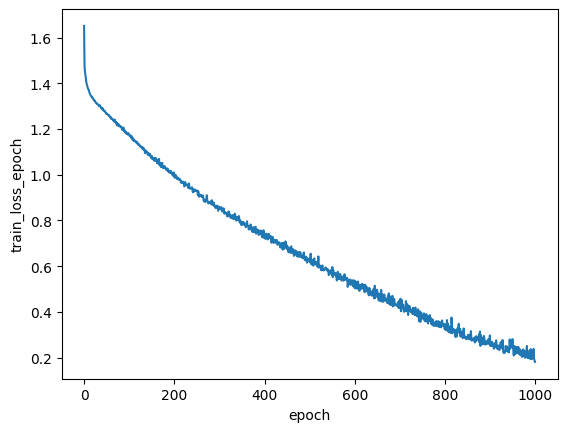

In [259]:
import seaborn as sns
metrics = pd.read_csv("logs/transformer/version_0/metrics.csv")
sns.lineplot(data=metrics, x="epoch", y="train_loss_epoch")

In [260]:
# compute R^2 to compare to linear reg
from torchmetrics import R2Score

# ... load best model
best_model = TransformerRegressor.load_from_checkpoint(
    best_model_callaback.best_model_path
)
best_model.to("cpu")

# ... get all data from dataloader
all_x = []
all_y = []
for x, y in cross_country_timeseries:
    all_x.append(x)
    all_y.append(y)
all_x = torch.stack(all_x, dim=0)
all_y = torch.stack(all_y, dim=0)

# ... inference
y_hat = best_model(all_x)

# ... scale back
def scale_back(y: torch.tensor) -> torch.tensor:
    """
    An ugly-but-it-works method to inverse scale a single feature
    """
    _y = y.detach().numpy().reshape(-1, 1).squeeze()
    _tmp = np.zeros((_y.shape[0], len(FEATURE_COLS)))
    _tmp[:, 0] = _y    # put y in it's original index
    return scaler.inverse_transform(_tmp)[:, 0]

y_hat = scale_back(y_hat)
all_y = scale_back(all_y)

# ... compute R^2
scorer = R2Score()
scorer.update(torch.tensor(y_hat), torch.tensor(all_y))
print(f"R^2 score: {scorer.compute()}")

R^2 score: 0.8517016908499265


Okay, so the model fits great on the train set. Not surprising when there are 53k params and only 1395 samples to train on. Memorization much?  

That's not the point though. The point is to see if the attention layer shows country-country correlations. Let's check that out.

# Results / Analysis

In [261]:
attention_maps = best_model.get_attention_maps(all_x)
attention_maps = attention_maps[0]    # since single layer transformer

In [262]:
attention_maps.shape

torch.Size([1395, 1, 20, 20])

In [301]:
def plot_attention_map(idx):
  year_week = list(df_agg_fill_feat_lag.groupby("year_week").groups.keys())

  sns.heatmap(
      pd.DataFrame(
          attention_maps[idx][0],
          columns=df_agg_fill_feat_lag.COUNTRY.unique()
      ),
      cmap="viridis",
      yticklabels=df_agg_fill_feat_lag.COUNTRY.unique(),
      cbar_kws={'label': 'Attention Activation'},
  ).set_title(f"Year-Week: {year_week[idx]}")

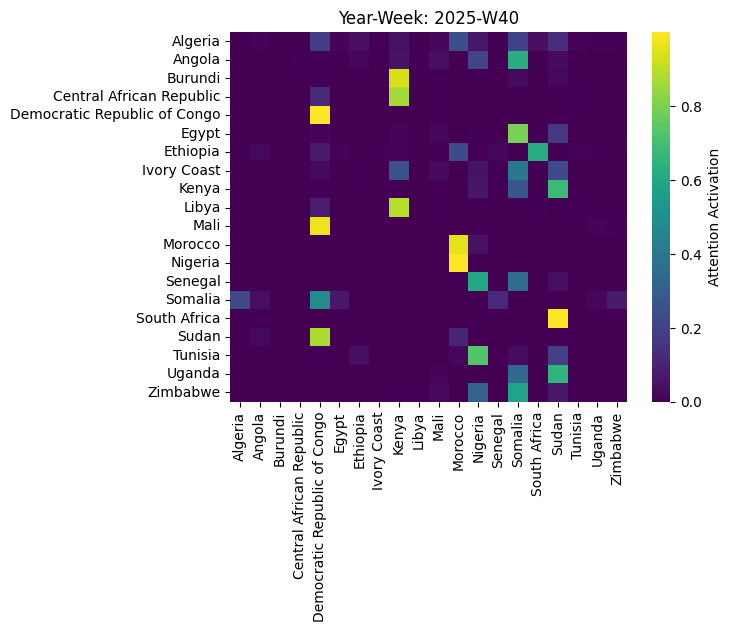

In [302]:
# plot an attention map
plot_attention_map(-1)

Interesting. In 2025-W40, lots of countries fatalities are correlated to the DRC, Kenya, Morocco, Nigeria, Somolia, and/or Sudan.

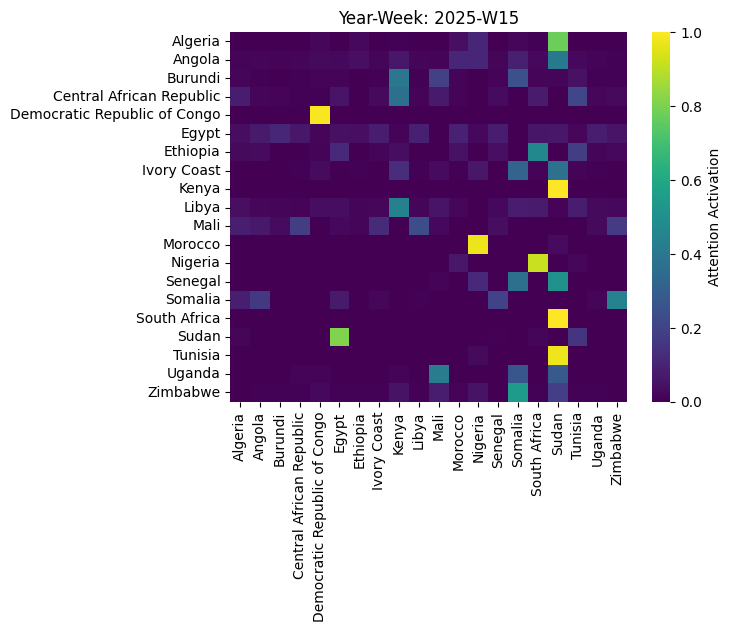

In [305]:
# plot another attention map - 26 weeks earlier
plot_attention_map(-26)

Similar, although DRC, Kenya, Morocco much less of a factor. Somalia and Sudan still light up.

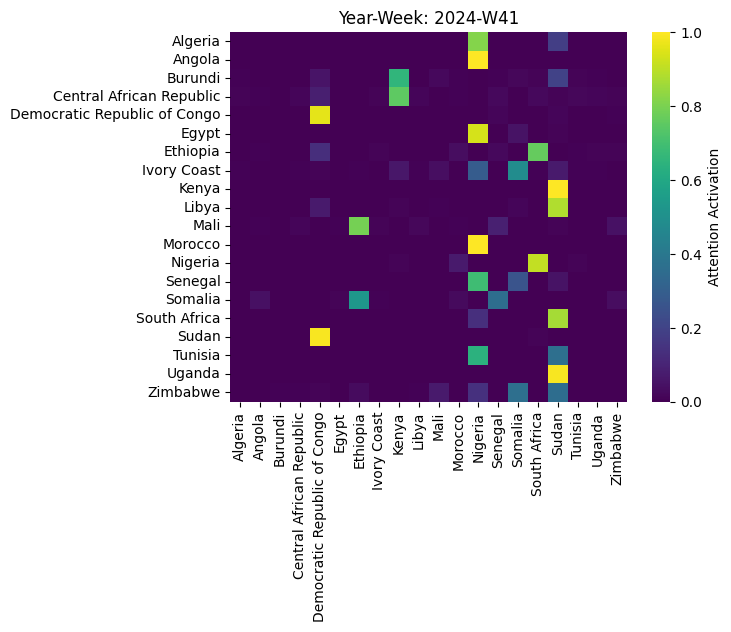

In [306]:
# plot another attention map - 52 weeks earlier
plot_attention_map(-52)

Very similar to 2025-W40, although Nigeria is more of a factor.